In [167]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [168]:
# 设置数据目录
DATA_DIR = "archive/cats_dogs/"
# 设置训练和测试目录
train_dir = DATA_DIR+"/train"
test_dir = DATA_DIR+"/test"

In [169]:
# get the train files
file_train = tf.io.gfile.glob(train_dir + '/*/*')
# shuffle 
file_train = tf.random.shuffle(file_train)

train_ds=file_train

# get the test files
file_test = tf.io.gfile.glob(test_dir + '/*/*')
# shuffle 
file_test = tf.random.shuffle(file_test)


test_ds=file_test
print("Shape of train data:- ", train_ds.shape)
print("Shape of test data:- ",file_test.shape)

Shape of train data:-  (210,)
Shape of test data:-  (67,)


In [170]:
# 获取音频的波形和标签
# Function to get waveform and it's label
def get_waveform_label(file):
  # get the label
  lab = tf.strings.split(file, os.path.sep)[-2]
  # read the binalry file 
  audio_binary = tf.io.read_file(file)
  # decode the file 
  audio, _ = tf.audio.decode_wav(audio_binary)
  # sqeeze tha audio
  waveform=tf.squeeze(audio, axis=-1)
  return waveform, lab

# get waveforms and labels of all files
AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

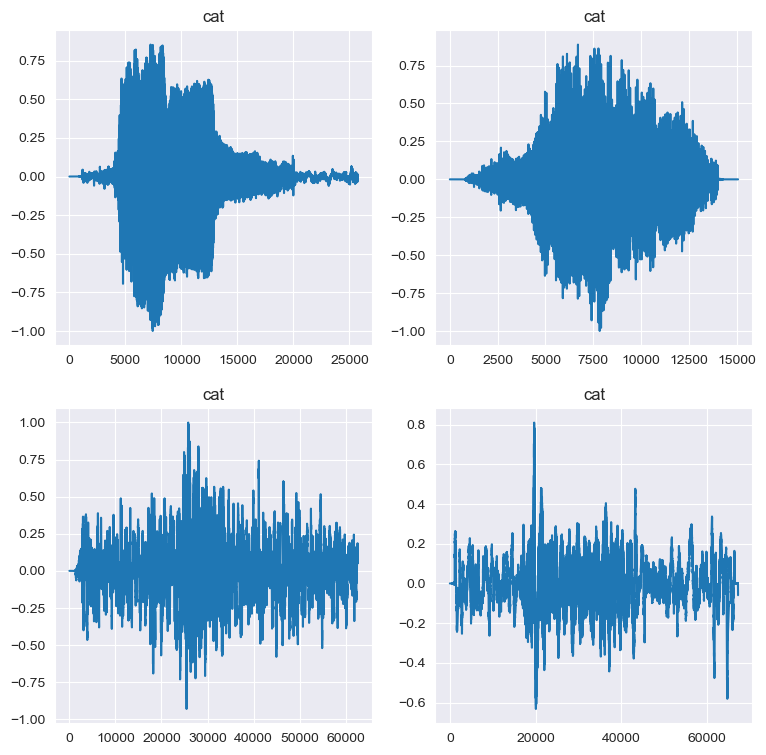

In [171]:
# number of rows and columns of plot
row,col = 2,2
n = row*col
fig, axs = plt.subplots(row, col, figsize=(9, 9))

# plotting waveforms
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // col
  c = i % col
  ax = axs[r][c]
  ax.plot(audio.numpy())

  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [172]:
# 创建频域特征
# function to get the spectogram and the labels
def get_spectrogram_label(audio, label):
  # apply padding
  padding = tf.zeros([300000] - tf.shape(audio), dtype=tf.float32)
  # get the spectogram of the audio
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(
      eq_length, frame_length=210, frame_step=110)    
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # get associated label of the audio
  label_id = tf.argmax(label == labels)
  # return the spectogram and the label
  return spectrogram, label_id

# get all the labels from the dataset   
labels = np.array(["cat","dog"])

# get the labels and spectogram
spectrogram_ds = waveform_ds.map(
    get_spectrogram_label, num_parallel_calls=AUTO)

C:\Users\33079\AppData\Local\Temp\ipykernel_19844\775024599.py:5: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


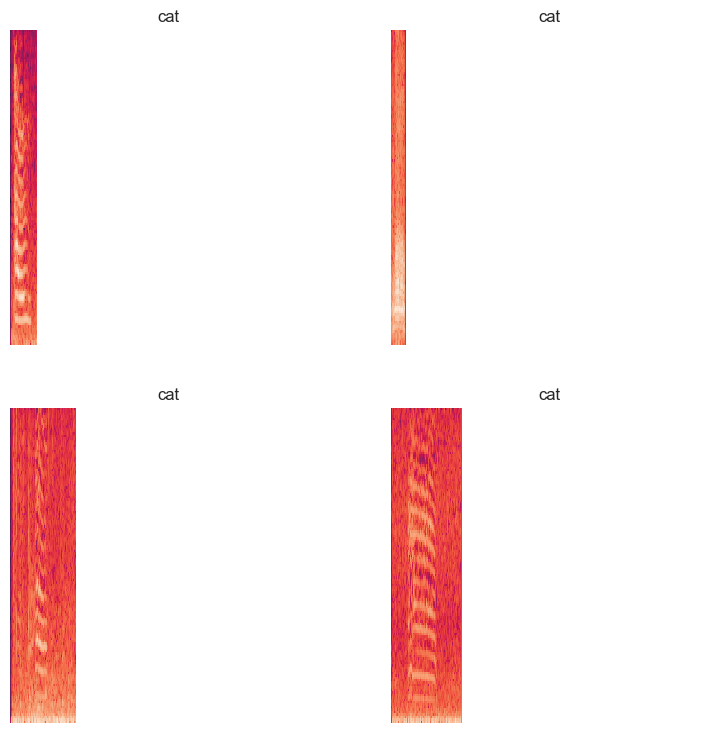

In [173]:
# 可视化频域特征
# function to plot the spectogram
def plot_spect(spectrogram, ax):
  # Converting frequencies to log and transpose to repesent time on x axis
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# plot using a subplot
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # function call
  plot_spect(np.squeeze(spectrogram.numpy()), ax)
  # set the title label
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')
plt.show()

In [174]:
# 预处理测试文件
# function to preprocess the data
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  # get waveforms and labels
  output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)
  # get spectogram and labels
  output_ds = output_ds.map(
      get_spectrogram_label,  num_parallel_calls=AUTO)
 # return the data
  return output_ds

# train test and validate data
train_ds = spectrogram_ds

test_ds = preprocess(test_ds)

In [175]:
# 创建tensorflow训练模型
# initialize a batch size
batch_size = 64
# batch train and validate data
train_ds = train_ds.batch(batch_size)
# cache and prefetch the data
train_ds = train_ds.cache().prefetch(AUTO)

In [176]:
# 构建网络模型
# building the model
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)
# normalize adapt 
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# adding layers

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (2726, 129, 1)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_14 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoo

In [177]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [178]:
EPOCHS = 15
history = model.fit(
    train_ds,  
    epochs=EPOCHS,
)

Epoch 1/15


D:\conda\envs\pytorch\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 1s 144ms/step - loss: 0.6287 - accuracy: 0.7238
Epoch 2/15
4/4 [==============================] - 0s 17ms/step - loss: 0.5591 - accuracy: 0.7857
Epoch 3/15
4/4 [==============================] - 0s 16ms/step - loss: 0.5339 - accuracy: 0.8143
Epoch 4/15
4/4 [==============================] - 0s 16ms/step - loss: 0.4815 - accuracy: 0.8190
Epoch 5/15
4/4 [==============================] - 0s 17ms/step - loss: 0.4391 - accuracy: 0.8571
Epoch 6/15
4/4 [==============================] - 0s 18ms/step - loss: 0.4154 - accuracy: 0.8333
Epoch 7/15
4/4 [==============================] - 0s 16ms/step - loss: 0.4215 - accuracy: 0.8619
Epoch 8/15
4/4 [==============================] - 0s 17ms/step - loss: 0.3209 - accuracy: 0.8810
Epoch 9/15
4/4 [==============================] - 0s 17ms/step - loss: 0.3211 - accuracy: 0.8667
Epoch 10/15
4/4 [==============================] - 0s 17ms/step - loss: 0.2873 - accuracy: 0.8667
Epoch 11/15
4/4 [======================

In [179]:
# 测试模型的分类准确率
# initialize empty list to save the audio and labels
t_audio = []
t_labels = []

# load in the labels and audio from test dataset
for audio, label in test_ds:
  t_audio.append(audio.numpy())
  t_labels.append(label.numpy())

# convert the lists to a numpy array
t_audio = np.array(t_audio)
t_labels = np.array(t_labels)

In [180]:
# Feed in the data for prediction
y_pred = np.argmax(model.predict(t_audio), axis=1)

# store the original labels for testing the accuracy
y_true = t_labels

# get the testing accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 [==============================] - 0s 23ms/step
Test set accuracy: 67%


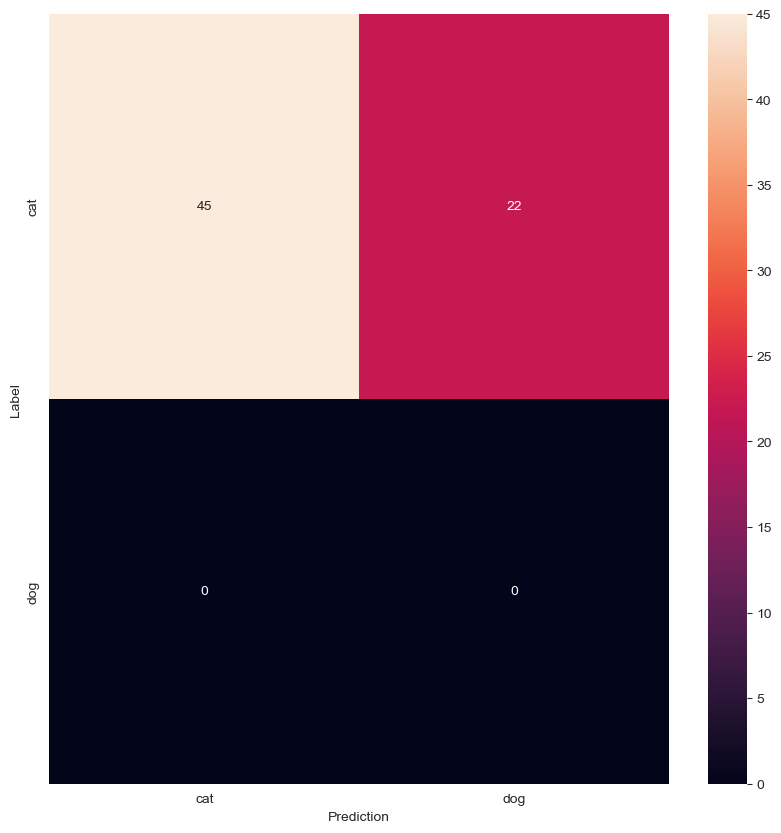

In [181]:
conf_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 10))
seaborn.heatmap(conf_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()